In [ ]:
# get data
import pandas as pd
from load_datasets import load_c4_ds1,load_c4_ds2b,load_BNCI_2
# ML stuff
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# series to series transformer
from sktime.transformations.series.detrend import Detrender

# panel to panel transformers
from sktime_neuro.transformations.panel.baselinecorrection import \
    BaselineCorrectionTransformer as Baseline
from sktime_neuro.transformations.panel.timeslicing import \
    TimeSlicingTransformer
from sktime_neuro.transformations.series.filterforseries import FilterforSeries
from sktime_neuro.transformations.series_to_panel.eeg_epoching import epoch

In [ ]:
def preprocessing_procedure(fs, data_train, annotation_train, labels, duration):
    detrended_data = Detrender().fit_transform(pd.DataFrame(data_train))
    filtered_data = FilterforSeries(l_freq=8, h_freq=15, sfreq=int(fs)).fit_transform(
        detrended_data
    )
    data_train, labels_train = epoch(
        Z=filtered_data,
        annotation=annotation_train,
        labels=labels,
        interval=[-0.5, duration],
        sfreq=fs,
    )
    print("shape of epoched data: " + str(data_train.shape))

    bl_corrected = Baseline(upper=0.5, fs=int(fs)).fit_transform(data_train)
    final_training = TimeSlicingTransformer(start=0.5, fs=int(fs)).fit_transform(
        bl_corrected
    )
    return final_training, labels_train

In [ ]:
def training_procedure(final_training, labels_train):
    # Assemble a classifier
    csp = CSP(transform_into="average_power")
    lda = LinearDiscriminantAnalysis()
    param_grid = {
        "CSP__n_components": [1, 2, 3, 4, 5, 7, 10],
    }

    # Use scikit-learn Pipeline with cross_val_score function
    pipe = Pipeline(steps=[("CSP", csp), ("LDA", lda)])

    search = GridSearchCV(pipe, param_grid, n_jobs=-1)
    search.fit(final_training, labels_train)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

## 1) First Dataset from 4th BCI Competition

- 2 classes (+ idle state), 7 subjects

In [ ]:
path = "Data/c4_ds1/"
fs, data_train, annotation_train = load_c4_ds1(path, subject="04", load="train")
final_training, labels = preprocessing_procedure(
    fs, data_train, annotation_train, labels=[-1, 1], duration=2.5
)
training_procedure(final_training, labels)

## 2) Second Dataset from 4th BCI Competition 

Data to be found at: http://www.bbci.de/competition/iv/#datasets

- 2 classes, 9 subjects

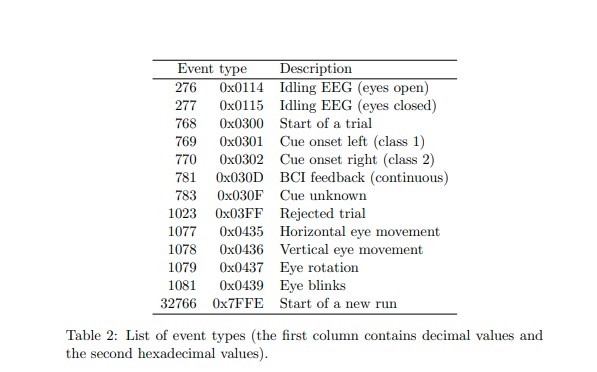

In [ ]:
path = "Data/c4_ds2b/"
fs, data_train, annotation_train = load_c4_ds2b(path=path, subject="04", load="train")
final_training, labels = preprocessing_procedure(
    fs, data_train, annotation_train, labels=["770", "769"], duration=2.5
)
training_procedure(final_training, labels)

## 2) Second Dataset from BNCI 2020

Data to be found at: http://bnci-horizon-2020.eu/database/data-sets

- 2 classes, 14 subjects

In [ ]:
path = "Data/bnci_2/"
fs, data_train, annotation_train = load_BNCI_2(path=path, subject="01")
final_training, labels = preprocessing_procedure(
    fs, data_train, annotation_train, labels=[1, 2], duration=5
)
training_procedure(final_training, labels)